**LIBRARIES AND SETUP**

Description:
This cell imports necessary Python libraries and sets up the environment for the data preprocessing pipeline.

In [1]:
# CICIDS2017 Data Preprocessing Notebook
# Traffic Source Classification and Operator Detection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import joblib
import warnings
warnings.filterwarnings('ignore')

print("CICIDS2017 Data Preprocessing Pipeline")
print("=" * 50)

CICIDS2017 Data Preprocessing Pipeline


**Drive Mounting**

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Description:
    * Configures paths and directories for data loading and output.


2. Variables Explanation:

    * DATA_PATH: Path to the raw dataset.
    * RANDOM_STATE: Ensures reproducibility (seed = 42).
    * timestamp: Captures the current time for output organization.
    * OUTPUT_BASE: Base directory for saving processed outputs.
    * OUTPUT_PATHS: Subdirectories for models, features, splits, visualizations, and encodings.
3. Action: Creates directories if they don’t exist.

In [3]:
DATA_PATH = '/content/drive/MyDrive/furssah/MachineLearningCVE/'
RANDOM_STATE = 42
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_BASE = f'/content/drive/MyDrive/furssah/preprocessing_output/'

# Create organized output directory structure
OUTPUT_PATHS = {
    'models': os.path.join(OUTPUT_BASE, 'models'),
    'features': os.path.join(OUTPUT_BASE, 'features'),
    'splits': os.path.join(OUTPUT_BASE, 'train_test_splits'),
    'visualizations': os.path.join(OUTPUT_BASE, 'visualizations'),
    'encodings': os.path.join(OUTPUT_BASE, 'encodings')
}

# Create directories if they don't exist
for path in OUTPUT_PATHS.values():
    os.makedirs(path, exist_ok=True)

**1. DATA LOADING AND INITIAL EXPLORATION**

1. Description:
 * Loads the CICIDS2017 dataset from multiple CSV files and combines them into a single DataFrame.

2. Function load_cicids_data Explanation:
  * Lists all CSV files in the dataset.
  * Reads each file, adds a source_file column, and concatenates them.
  * Prints the number of records loaded per file and the total combined dataset shape.


3. Output: Confirms successful loading of 2,830,743 records with 80 features.

In [4]:
def load_cicids_data(data_path):
    """Load all CICIDS2017 CSV files and combine them"""
    csv_files = [
        "Monday-WorkingHours.pcap_ISCX.csv",
        "Tuesday-WorkingHours.pcap_ISCX.csv",
        "Wednesday-workingHours.pcap_ISCX.csv",
        "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
        "Friday-WorkingHours-Morning.pcap_ISCX.csv",
        "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
    ]

    dataframes = []
    for file in csv_files:
        try:
            df = pd.read_csv(f"{data_path}/{file}")
            df['source_file'] = file
            dataframes.append(df)
            print(f"Loaded {file}: {df.shape[0]} records")
        except FileNotFoundError:
            print(f"Warning: {file} not found, skipping...")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"\nTotal combined dataset: {combined_df.shape[0]} records, {combined_df.shape[1]} features")
        return combined_df
    else:
        print("No data files found. Please check the data path.")
        return None

# Load the dataset
print("Loading CICIDS2017 dataset...")
df = load_cicids_data(DATA_PATH)

if df is not None:
    print(f"Dataset loaded successfully: {df.shape}")
    print(f"Columns: {list(df.columns[:10])}...")  # Show first 10 columns

Loading CICIDS2017 dataset...
Loaded Monday-WorkingHours.pcap_ISCX.csv: 529918 records
Loaded Tuesday-WorkingHours.pcap_ISCX.csv: 445909 records
Loaded Wednesday-workingHours.pcap_ISCX.csv: 692703 records
Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv: 170366 records
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: 288602 records
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv: 191033 records
Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: 225745 records
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: 286467 records

Total combined dataset: 2830743 records, 80 features
Dataset loaded successfully: (2830743, 80)
Columns: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std']...


**2. DATA EXPLORATION AND QUALITY ASSESSMENT**

1. Description:
  * Explores the dataset, checks for missing/infinite values, and derives traffic labels.

2. Explanation:

  * Basic Info: Prints dataset shape and memory usage (~2.1 GB).
  * Label Analysis:
  * Label column shows traffic types (e.g., "BENIGN", "DoS Hulk").
  * Derived columns: traffic_source (BENIGN/MALICIOUS) and operator_type (AUTOMATED/HUMAN/BENIGN).
3. Output: Shows distributions of traffic types, sources, and operator types.

In [5]:
    print("\n" + "="*50)
    print("DATA EXPLORATION")
    print("="*50)

    # Basic info
    print("Dataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Check for label column
    label_col = 'Label' if 'Label' in df.columns else ' Label'
    if label_col in df.columns:
        print(f"\nTraffic Types Distribution:")
        print(df[label_col].value_counts())

        # Create traffic source categories
        df['traffic_source'] = df[label_col].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'MALICIOUS')
        print(f"\nTraffic Source Distribution:")
        print(df['traffic_source'].value_counts())

        # Create operator type (human vs automated)
        automated_attacks = ['Bot', 'DDoS', 'DoS', 'PortScan']
        df['operator_type'] = df[label_col].apply(
            lambda x: 'AUTOMATED' if any(attack in str(x) for attack in automated_attacks)
            else 'HUMAN' if x != 'BENIGN' else 'BENIGN'
        )
        print(f"\nOperator Type Distribution:")
        print(df['operator_type'].value_counts())


DATA EXPLORATION
Dataset Info:
Shape: (2830743, 80)
Memory usage: 2121.30 MB

Traffic Types Distribution:
 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Traffic Source Distribution:
traffic_source
BENIGN       2273097
MALICIOUS     557646
Name: count, dtype: int64

Operator Type Distribution:
operator_type
BENIGN       2273097
AUTOMATED     541584
HUMAN          16062
Name: count, dtype: int64


**3. DATA CLEANING**

1. Description:
  * Handles missing and infinite values in the dataset.

2. Explanation:

  * Missing Values: Identifies 1,358 missing values in Flow Bytes/s.
  * Infinite Values: Replaces infinite values in Flow Bytes/s and Flow Packets/s with column medians.
  
3. Output: Reports cleaning actions.

In [6]:
    print("\n" + "="*50)
    print("DATA CLEANING")
    print("="*50)

    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values found:")
        print(missing_values[missing_values > 0])
    else:
        print("No missing values found.")

    # Check for infinite values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_counts = {}
    for col in numeric_cols:
        inf_count = np.isinf(df[col]).sum()
        if inf_count > 0:
            inf_counts[col] = inf_count

    if inf_counts:
        print(f"\nInfinite values found in {len(inf_counts)} columns:")
        for col, count in inf_counts.items():
            print(f"  {col}: {count} infinite values")

        # Replace infinite values with NaN, then fill with median
        df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
        print("Infinite values replaced with median values.")


DATA CLEANING
Missing values found:
Flow Bytes/s    1358
dtype: int64

Infinite values found in 2 columns:
  Flow Bytes/s: 1509 infinite values
   Flow Packets/s: 2867 infinite values
Infinite values replaced with median values.


**4. FEATURE ENGINEERING**

1. Description:
  * Creates new features to enhance model performance.

2. New Features Explanation:

  * protocol_category (TCP/UDP/ICMP/OTHER).
  * flow_duration_log (log-transformed flow duration).
  * is_long_flow (binary flag for long flows).
  * total_packets and packet_ratio (packet metrics).
  * flow_rate_category (LOW/MEDIUM/HIGH/VERY_HIGH).
  * Z-score-based outlier indicators.

3. Output: Indicates zero new features were created (likely due to missing columns).

In [7]:
    print("\n" + "="*50)
    print("FEATURE ENGINEERING")
    print("="*50)

    # Extract network protocol information
    if 'Protocol' in df.columns:
        df['protocol_category'] = df['Protocol'].map({6: 'TCP', 17: 'UDP', 1: 'ICMP'})
        df['protocol_category'].fillna('OTHER', inplace=True)
        print("Protocol categories created.")

    # Create flow-based features
    flow_features = []

    # Duration-based features
    if 'Flow Duration' in df.columns:
        df['flow_duration_log'] = np.log1p(df['Flow Duration'])
        df['is_long_flow'] = (df['Flow Duration'] > df['Flow Duration'].quantile(0.75)).astype(int)
        flow_features.extend(['flow_duration_log', 'is_long_flow'])

    # Packet size features
    if 'Total Fwd Packets' in df.columns and 'Total Backward Packets' in df.columns:
        df['total_packets'] = df['Total Fwd Packets'] + df['Total Backward Packets']
        df['packet_ratio'] = df['Total Fwd Packets'] / (df['total_packets'] + 1e-10)
        flow_features.extend(['total_packets', 'packet_ratio'])

    # Flow rate features
    if 'Flow Packets/s' in df.columns:
        df['flow_rate_category'] = pd.cut(df['Flow Packets/s'],
                                        bins=[0, 10, 100, 1000, np.inf],
                                        labels=['LOW', 'MEDIUM', 'HIGH', 'VERY_HIGH'])
        flow_features.append('flow_rate_category')

    # Anomaly indicators
    statistical_features = []
    for col in ['Packet Length Mean', 'Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std']:
        if col in df.columns:
            # Z-score for anomaly detection
            df[f'{col}_zscore'] = np.abs((df[col] - df[col].mean()) / df[col].std())
            df[f'{col}_is_outlier'] = (df[f'{col}_zscore'] > 3).astype(int)
            statistical_features.extend([f'{col}_zscore', f'{col}_is_outlier'])

    print(f"Created {len(flow_features + statistical_features)} new features.")


FEATURE ENGINEERING
Created 0 new features.


**5. FEATURE SELECTION AND PREPARATION**

- Description: Selects network flow and engineered features for modeling.
- Explanation: Chooses 31 predefined network features (e.g., Flow Duration, Flow Bytes/s) and engineered features if in the dataset, storing them in feature_columns. Prints the count and first 10 features.
- Role: Curates relevant features ( 7 selected) to reduce dimensionality.

In [8]:
    print("\n" + "="*50)
    print("FEATURE SELECTION")
    print("="*50)

    # Select relevant features for training
    feature_columns = []

    # Network flow features
    network_features = [
        'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
        'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
        'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
        'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
        'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std',
        'Fwd IAT Total', 'Fwd IAT Mean', 'Bwd IAT Total', 'Bwd IAT Mean',
        'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
        'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
        'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std'
    ]

    # Add existing features that are in the dataset
    for feature in network_features:
        if feature in df.columns:
            feature_columns.append(feature)

    # Add engineered features
    feature_columns.extend([f for f in flow_features + statistical_features if f in df.columns])

    print(f"Selected {len(feature_columns)} features for training:")
    print(feature_columns[:10], "...")


FEATURE SELECTION
Selected 7 features for training:
['Total Length of Fwd Packets', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Fwd IAT Total', 'Bwd IAT Total', 'Fwd PSH Flags', 'Fwd Packets/s'] ...


**6. DATA PREPROCESSING FOR ML**

- Description: Preprocesses features and targets for ML.
- Explanation: Extracts features (X), encodes categorical columns with LabelEncoder, defines three targets (attack_type, traffic_source, operator_type), samples 100,000 records to balance classes, and scales features with StandardScaler.
- Role: Prepares scaled features and targets, addressing imbalance and ML compatibility.

In [9]:
    print("\n" + "="*50)
    print("ML PREPROCESSING")
    print("="*50)

    # Prepare features and targets
    X = df[feature_columns].copy()

    # Handle categorical features
    categorical_features = X.select_dtypes(include=['object']).columns
    if len(categorical_features) > 0:
        print(f"Encoding {len(categorical_features)} categorical features...")
        le = LabelEncoder()
        for col in categorical_features:
            X[col] = le.fit_transform(X[col].astype(str))

    # Prepare multiple target variables for different tasks
    targets = {}

    if label_col in df.columns:
        # Multi-class attack classification
        targets['attack_type'] = df[label_col].copy()

        # Binary classification: benign vs malicious
        targets['traffic_source'] = df['traffic_source'].copy()

        # Operator type classification
        targets['operator_type'] = df['operator_type'].copy()

    # Handle class imbalance through stratified sampling
    print("Handling class imbalance...")

    # Sample dataset for balanced training (optional - remove if you want full dataset)
    # This helps with memory and training time
    sample_size = min(100000, len(df))  # Adjust as needed

    if len(df) > sample_size:
        df_sampled = df.sample(n=sample_size, random_state=RANDOM_STATE)
        X_sampled = X.loc[df_sampled.index]
        targets_sampled = {k: v.loc[df_sampled.index] for k, v in targets.items()}
        print(f"Sampled {sample_size} records for training")
    else:
        X_sampled = X
        targets_sampled = targets
        print("Using full dataset")

    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_sampled),
        columns=X_sampled.columns,
        index=X_sampled.index
    )

    print("Features scaled using StandardScaler")


ML PREPROCESSING
Handling class imbalance...
Sampled 100000 records for training
Features scaled using StandardScaler


**7. TRAIN-TEST SPLITS**

- Description: Creates stratified train-test splits for each target.
- Explanation: Splits X_scaled and targets into 80/20 train-test sets with train_test_split, using stratification. Stores splits in a dictionary and prints sizes and training class distributions.
- Role: Generates balanced splits (80,000 train, 20,000 test) for training/evaluation

In [10]:
    print("\n" + "="*50)
    print("CREATING TRAIN-TEST SPLITS")
    print("="*50)

    splits = {}

    for target_name, target_data in targets_sampled.items():
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, target_data,
            test_size=0.2,
            random_state=RANDOM_STATE,
            stratify=target_data
        )

        splits[target_name] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }

        print(f"{target_name}: Train={len(X_train)}, Test={len(X_test)}")
        print(f"  Train distribution: {y_train.value_counts().to_dict()}")


CREATING TRAIN-TEST SPLITS
attack_type: Train=80000, Test=20000
  Train distribution: {'BENIGN': 64182, 'DoS Hulk': 6485, 'PortScan': 4471, 'DDoS': 3711, 'DoS GoldenEye': 300, 'FTP-Patator': 243, 'DoS slowloris': 165, 'DoS Slowhttptest': 162, 'SSH-Patator': 155, 'Bot': 55, 'Web Attack � Brute Force': 47, 'Web Attack � XSS': 22, 'Infiltration': 2}
traffic_source: Train=80000, Test=20000
  Train distribution: {'BENIGN': 64182, 'MALICIOUS': 15818}
operator_type: Train=80000, Test=20000
  Train distribution: {'BENIGN': 64182, 'AUTOMATED': 15349, 'HUMAN': 469}


**8. SAVE PREPROCESSED DATA**

- Description: Saves preprocessing artifacts and creates a README.
- Explanation: Saves scaler (scaler.joblib), feature names (feature_names.txt), train-test splits (CSVs), encoded targets, and label encoders (label_encoders.joblib). Saves a plot and writes a README with pipeline details. Verifies output directories.
- Role: Organizes artifacts for reproducibility and training use.

In [19]:
print("\n" + "="*50)
print("SAVING PREPROCESSED DATA - ORGANIZED STRUCTURE")
print("="*50)

# Save scaler and models
joblib.dump(scaler, os.path.join(OUTPUT_PATHS['models'], 'scaler.joblib'))
print(f"Scaler saved to '{OUTPUT_PATHS['models']}/scaler.joblib'")

# Save feature names
with open(os.path.join(OUTPUT_PATHS['features'], 'feature_names.txt'), 'w') as f:
    for feature in feature_columns:
        f.write(f"{feature}\n")
print(f"Feature names saved to '{OUTPUT_PATHS['features']}/feature_names.txt'")

# Save train-test splits
for target_name, split_data in splits.items():
    for split_type, data in split_data.items():
        filename = os.path.join(OUTPUT_PATHS['splits'], f"{target_name}_{split_type}.csv")
        data.to_csv(filename, index=False)
        print(f"Saved {filename}")

# Save label encodings
label_encoders = {}
for target_name, target_data in targets_sampled.items():
    if target_data.dtype == 'object':
        le = LabelEncoder()
        target_encoded = le.fit_transform(target_data)
        label_encoders[target_name] = le

        # Save encoded targets
        pd.Series(target_encoded, index=target_data.index).to_csv(
            os.path.join(OUTPUT_PATHS['encodings'], f"{target_name}_encoded.csv"),
            index=False
        )

joblib.dump(label_encoders, os.path.join(OUTPUT_PATHS['models'], 'label_encoders.joblib'))
print(f"Label encoders saved to '{OUTPUT_PATHS['models']}/label_encoders.joblib'")

# Create README file
readme_content = f"""
CICIDS2017 Preprocessing Output - {timestamp}

Directory Structure:
- models/: Contains serialized preprocessing models (scaler, encoders)
- features/: Contains feature lists and metadata
- train_test_splits/: Contains training and testing splits
- visualizations/: Contains exploratory data analysis plots
- encodings/: Contains encoded target variables

Preprocessing Parameters:
- Random State: {RANDOM_STATE}
- Sample Size: {sample_size if 'sample_size' in locals() else 'Full dataset'}
- Features Used: {len(feature_columns)}
- Targets Generated: {', '.join(targets.keys())}
"""

with open(os.path.join(OUTPUT_BASE, 'README.md'), 'w') as f:
    f.write(readme_content)
print(f"README saved to '{OUTPUT_BASE}/README.md'")

# Verify all paths were created successfully
print("\nOutput directory verification:")
for name, path in OUTPUT_PATHS.items():
    if os.path.exists(path):
        print(f"✓ {name.ljust(15)}: {path}")
    else:
        print(f"✗ {name.ljust(15)}: Failed to create")


SAVING PREPROCESSED DATA - ORGANIZED STRUCTURE
Scaler saved to '/content/drive/MyDrive/furssah/preprocessing_output/models/scaler.joblib'
Feature names saved to '/content/drive/MyDrive/furssah/preprocessing_output/features/feature_names.txt'
Saved /content/drive/MyDrive/furssah/preprocessing_output/train_test_splits/attack_type_X_train.csv
Saved /content/drive/MyDrive/furssah/preprocessing_output/train_test_splits/attack_type_X_test.csv
Saved /content/drive/MyDrive/furssah/preprocessing_output/train_test_splits/attack_type_y_train.csv
Saved /content/drive/MyDrive/furssah/preprocessing_output/train_test_splits/attack_type_y_test.csv
Saved /content/drive/MyDrive/furssah/preprocessing_output/train_test_splits/traffic_source_X_train.csv
Saved /content/drive/MyDrive/furssah/preprocessing_output/train_test_splits/traffic_source_X_test.csv
Saved /content/drive/MyDrive/furssah/preprocessing_output/train_test_splits/traffic_source_y_train.csv
Saved /content/drive/MyDrive/furssah/preprocessing_

**9. DATA VISUALIZATION AND SUMMARY**

- Description: Visualizes data distributions and summarizes preprocessing.
- Explanation: Plots traffic_source and operator_type bar charts, Flow Duration histogram (log-scaled), and a correlation heatmap for top  features. Prints record count, feature count, targets, and output structure.
- Role: Provides data insights and confirms preprocessing completion


DATA SUMMARY AND VISUALIZATION
Visualization saved to '/content/drive/MyDrive/furssah/preprocessing_output/visualizations/data_distributions.png'


<Figure size 1500x1200 with 0 Axes>

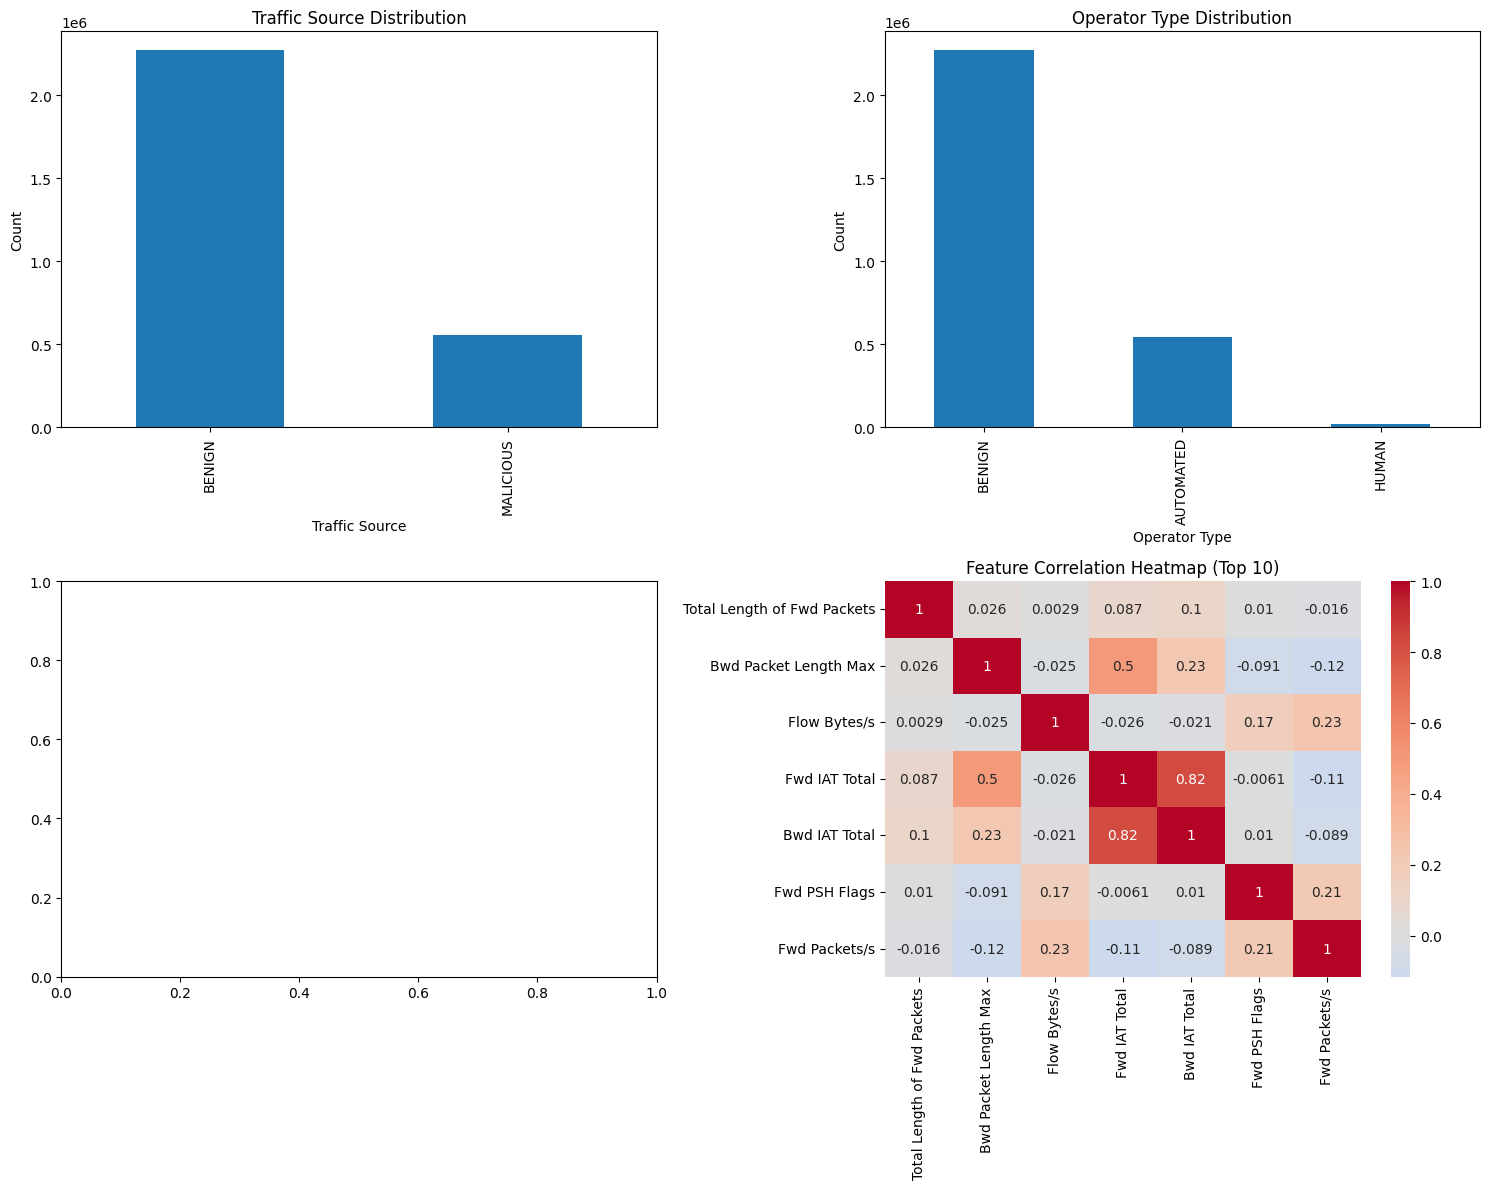


PREPROCESSING COMPLETE
Total records processed: 2,830,743
Features selected: 7
Target variables created: 3

Output saved to: /content/drive/MyDrive/furssah/preprocessing_output/

Folder structure created:
├── models/
├── features/
├── train_test_splits/
├── visualizations/
└── encodings/

Dataset is ready for model training!


In [16]:
print("\n" + "="*50)
print("DATA SUMMARY AND VISUALIZATION")
print("="*50)

# Ensure a new figure is created and set white background
plt.figure(figsize=(15, 12), facecolor='white')  # Explicitly create a new figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12), facecolor='white')

# Set axes background to white
for ax in axes.flatten():
    ax.set_facecolor('white')

# Traffic source distribution
df['traffic_source'].value_counts().plot(kind='bar', ax=axes[0,0], title='Traffic Source Distribution')
axes[0,0].set_xlabel('Traffic Source')
axes[0,0].set_ylabel('Count')

# Operator type distribution
df['operator_type'].value_counts().plot(kind='bar', ax=axes[0,1], title='Operator Type Distribution')
axes[0,1].set_xlabel('Operator Type')
axes[0,1].set_ylabel('Count')

# Flow duration distribution (log scale)
if 'Flow Duration' in df.columns:
    df['Flow Duration'].apply(lambda x: np.log1p(x)).hist(bins=50, ax=axes[1,0], title='Flow Duration Distribution (Log Scale)')
    axes[1,0].set_xlabel('Log(Flow Duration + 1)')
    axes[1,0].set_ylabel('Frequency')

# Feature correlation heatmap (top 10 features)
top_features = feature_columns[:10]
correlation_matrix = X_scaled[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Feature Correlation Heatmap (Top 10)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to the visualizations folder
save_path = os.path.join(OUTPUT_PATHS['visualizations'], 'data_distributions.png')
plt.savefig(
    save_path,
    dpi=300,
    bbox_inches='tight',
    facecolor='white',
    edgecolor='none'
)
print(f"Visualization saved to '{save_path}'")

# Display the plot
plt.show()

# Close the figure to free memory and prevent reuse
plt.close(fig)

# Final summary
print("\n" + "="*50)
print("PREPROCESSING COMPLETE")
print("="*50)

print(f"Total records processed: {len(df):,}")
print(f"Features selected: {len(feature_columns)}")
print(f"Target variables created: {len(targets)}")
print(f"\nOutput saved to: {OUTPUT_BASE}")
print("\nFolder structure created:")
print(f"├── models/")
print(f"├── features/")
print(f"├── train_test_splits/")
print(f"├── visualizations/")
print(f"└── encodings/")
print("\nDataset is ready for model training!")

**HELPER FUNCTIONS FOR REAL-TIME PROCESSING**

- Description: Defines a function for real-time flow preprocessing.
- Explanation: preprocess_realtime_sample converts a flow dictionary to a DataFrame, adds missing features, handles infinite/NaN values, and scales with the provided scaler. Prints completion message.
- Role: Enables real-time prediction by preprocessing single flows consistently.

In [13]:
def preprocess_realtime_sample(sample_dict, scaler, feature_names):
    """
    Preprocess a single network flow sample for real-time prediction

    Args:
        sample_dict: Dictionary containing flow features
        scaler: Fitted StandardScaler object
        feature_names: List of expected feature names

    Returns:
        Preprocessed feature vector ready for prediction
    """
    # Create DataFrame from sample
    sample_df = pd.DataFrame([sample_dict])

    # Add missing features with default values
    for feature in feature_names:
        if feature not in sample_df.columns:
            sample_df[feature] = 0

    # Select and order features
    sample_df = sample_df[feature_names]

    # Handle infinite and NaN values
    sample_df = sample_df.replace([np.inf, -np.inf], np.nan)
    sample_df = sample_df.fillna(0)

    # Scale features
    sample_scaled = scaler.transform(sample_df)

    return sample_scaled

print("\nPreprocessing notebook complete!")
print("Next step: Run the Model Training notebook")


Preprocessing notebook complete!
Next step: Run the Model Training notebook
